In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_columns', 100)

In [21]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# User Latent Features

In [23]:
user_factors = pd.read_csv('data/user_factors.csv')

In [24]:
user_factors.head()

,id,features
0,640,"[0.5853673219680786, 1.1955639123916626, 0.495..."
1,650,"[0.7357923984527588, 1.1214193105697632, 0.211..."
2,660,"[0.41824525594711304, 0.8636453151702881, 0.40..."
3,670,"[0.0, 0.23701752722263336, 0.10014515370130539..."
4,680,"[0.2757687568664551, 0.9952836632728577, 0.413..."


# Movie Latent Features

In [25]:
movie_factors = pd.read_csv('data/movie_factors.csv')

In [26]:
movie_factors['features'][0]

'[0.1470944583415985, 1.0527691841125488, 0.06695104390382767, 0.2533167600631714, 0.17517654597759247, 0.5150220990180969, 0.18830619752407074, 0.5612077713012695, 0.11690513044595718, 0.7164477705955505]'

# Requests Data

In [27]:
requests_df = pd.read_csv('data/requests.csv')

In [28]:
requests_df.head()

,user,movie
0,4958,1924
1,4958,3264
2,4958,2634
3,4958,1407
4,4958,2399


# Training Data

In [29]:
training = pd.read_csv('data/training.csv')

In [30]:
training.head()

,user,movie,rating,timestamp
0,6040,858,4,956703932
1,6040,593,5,956703954
2,6040,2384,4,956703954
3,6040,1961,4,956703977
4,6040,2019,5,956703977


In [31]:
training['movie'].nunique()

3662

In [32]:
print('Training data statistics: ')
training.describe()

Training data statistics: 


,user,movie,rating,timestamp
count,800000.000000,800000.000000,800000.000000,8.000000e+05
mean,3403.097837,1849.257256,3.590479,9.683921e+08
std,1546.589028,1086.852485,1.120376,5.820931e+06
min,636.000000,1.000000,1.000000,9.567039e+08
25%,2035.000000,1028.000000,3.000000,9.641524e+08
50%,3507.000000,1788.000000,4.000000,9.675878e+08
75%,4695.000000,2750.000000,4.000000,9.746878e+08
max,6040.000000,3952.000000,5.000000,9.757673e+08


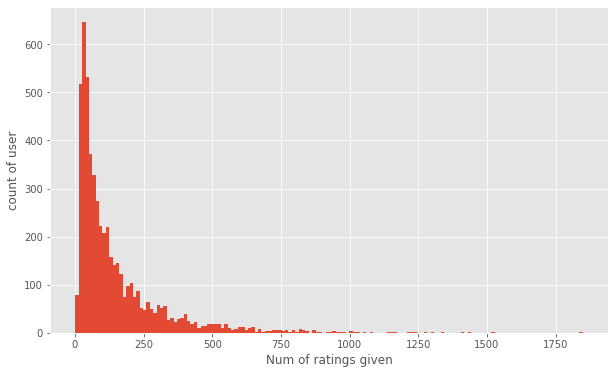

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(training.groupby('user').count()['rating'], bins=150)
ax.set_xlabel('Num of ratings given')
ax.set_ylabel('count of user');

# Movie Descriptions

In [34]:
movies = pd.read_csv('data/movies.dat', sep='::', engine='python', names=['movie_id', 'title', 'genre'])

In [35]:
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [44]:
movies['genre'] = movies['genre'].apply(lambda x: x.replace('|', ' '))

In [37]:
movies.describe()

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [38]:
movies['genre'].unique()

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance',
       'Comedy|Horror', "Animation|Children's", 'Drama',
       'Action|Adventure|Romance', 'Drama|Thriller', 'Drama|Romance',
       'Thriller', 'Action|Comedy|Drama', 'Crime|Drama|Thriller',
       'Drama|Sci-Fi', 'Romance', 'Adventure|Sci-Fi', 'Adventure|Romance',
       "Children's|Comedy|Drama", 'Documentary', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure', 'Crime|Thriller',
       "Animation|Children's|Musical|Romance", 'Action|Drama|Thriller',
       "Children's|Comedy", 'Drama|Mystery', 'Sci-Fi|Thriller',
       'Action|Comedy|Crime|Horror|Thriller', 'Drama|Musical',
       'Crime|Drama|Romance', 'Adventure|Drama', 'Action|Thriller',
       "Adventure|Children's|Comedy|Musical", 'Action|Drama|War',
       'Action|Adventur

In [46]:
movies.set_index('movie_id', inplace=True)

In [48]:
movies_df = movies.copy().drop('title', axis=1)

In [189]:
movies_df.to_csv('data/movies.csv')

In [65]:
tf = TfidfVectorizer()
movies_tfidf = tf.fit_transform(movies_df['genre'])
movies_indices = pd.Series(movies_df.index)

In [176]:
movies_sim_mat = pd.DataFrame(cosine_similarity(movies_tfidf), index=movies_indices, columns=movies_indices)

In [207]:
# movies_sim_mat.to_csv('data/movies_sim_mat.csv')
print('Movies Cosine Similarity Matrix: ')
movies_sim_mat.head(10)

Movies Cosine Similarity Matrix: 


movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.305525,0.197372,0.260194,0.344351,0.000000,0.197372,0.425153,0.000000,0.000000,0.176755,0.184560,0.938841,0.000000,0.000000,0.000000,0.000000,0.000000,0.344351,0.000000,0.178778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.627557,0.000000,0.000000,0.0,0.344351,0.197372,0.000000,0.000000,0.000000,0.000000,0.000000,0.260194,0.000000,0.000000,0.689027,0.000000,0.000000,...,0.000000,0.000000,0.344351,0.000000,0.000000,0.0,0.197372,0.000000,0.344351,0.260194,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.344351,0.344351,0.0,0.344351,0.344351,0.000000,0.000000,0.184560,0.344351,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.344351,0.260194,0.801460,0.000000,0.000000,0.344351,0.000000,0.000000,0.000000,0.000000
2,0.305525,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.718623,0.000000,0.320890,0.000000,0.000000,0.325428,0.000000,0.319540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.287244,0.000000,0.000000,0.000000,0.379045,0.409075,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382454,0.000000,0.000000,0.000000,0.238835,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.651211,0.000000,0.000000,0.0,0.000000,0.000000,0.287244,0.287244,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.538118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.197372,0.000000,1.000000,0.433093,0.573172,0.000000,1.000000,0.000000,0.000000,0.000000,0.895543,0.307200,0.000000,0.000000,0.450274,0.000000,0.700684,0.000000,0.573172,0.000000,0.297576,0.000000,0.000000,0.000000,0.700684,0.000000,0.000000,0.819435,0.000000,0.000000,0.000000,0.000000,0.534124,0.264266,0.700684,0.000000,0.0,0.573172,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.433093,0.700684,0.000000,0.315353,0.700684,0.000000,...,0.000000,0.000000,0.573172,0.000000,0.000000,0.0,1.000000,0.000000,0.573172,0.433093,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.573172,0.573172,0.0,0.573172,0.573172,0.000000,0.000000,0.307200,0.573172,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.573172,0.433093,0.000000,0.000000,0.000000,0.573172,0.000000,0.000000,0.000000,0.000000
4,0.260194,0.000000,0.433093,1.000000,0.755606,0.000000,0.433093,0.000000,0.000000,0.000000,0.679323,0.404979,0.000000,0.655026,0.000000,0.343133,0.339626,0.000000,0.755606,0.000000,0.687095,0.232383,0.000000,0.225132,0.339626,0.655026,0.655026,0.000000,0.000000,0.655026,0.655026,0.225132,0.000000,0.610184,0.339626,0.655026,0.0,0.755606,0.433093,0.655026,0.263178,0.232940,0.655026,0.000000,1.000000,0.339626,0.000000,0.000000,0.339626,0.000000,...,0.655026,0.655026,0.755606,0.000000,0.655026,0.0,0.433093,0.252066,0.755606,1.000000,0.0,0.655026,0.655026,0.655026,0.0,0.0,0.0,0.229773,0.755606,0.755606,0.0,0.755606,0.755606,0.000000,0.000000,0.404979,0.755606,0.0,0.0,0.0,0.0,0.0,0.0,0.343133,0.000000,0.0,0.0,0.0,0.0,0.0,0.755606,1.000000,0.000000,0.262005,0.000000,0.755606,0.655026,0.655026,0.655026,0.343133
5,0.344351,0.000000,0.573172,0.755606,1.000000,0.000000,0.573172,0.000000,0.000000,0.000000,0.513301,0.535965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.519173,0.000000,0.000000,0.000000,0.00

In [208]:
movie_id = 2

In [217]:
# find similarity of GIVEN movie_id and movie_id 193
# USE .LOC BECAUSE INDEXING THE NAMES
movies_sim_mat.loc[movie_id, 3]

0.0

In [219]:
np.sort(movies_sim_mat[movie_id])

array([0., 0., 0., ..., 1., 1., 1.])

In [225]:
movies_sim_mat.loc[2, 1897]

0.0

In [237]:
# sorts movie_ids by similarity values from greatest to smallest
# try:
movies_sim_mat.loc[movies_sim_mat[movie_id].sort_values(ascending=False)>=1]
# except:
#     movies_sim_mat.loc[movies_sim_mat[movie_id].sort_values(ascending=False) >= 0.9]

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1967,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2043,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.

In [258]:
movies_sim_mat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3883 entries, 1 to 3952
Columns: 3883 entries, 1 to 3952
dtypes: float64(3883)
memory usage: 115.2 MB


In [309]:
movies_sim_mat.loc[762, 761]

0.0

In [325]:
similar_movie_ids = movies_sim_mat.loc[round(movies_sim_mat[movie_id].sort_values(ascending=False), 5) >= 1][1:5].index.values

In [327]:
movies_sim_mat.loc[movies_sim_mat[movie_id].sort_values(ascending=False) >= 1][1:5]

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,3903,3904,3905,3906,3907,3908,3909,3910,3911,3912,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
126,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009,0.305525,1.0,0.0,0.0,0.0,0.0,0.0,0.718623,0.0,0.32089,0.0,0.0,0.325428,0.0,0.31954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.287244,0.0,0.0,0.0,0.379045,0.409075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.382454,0.0,0.0,0.0,0.238835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.651211,0.0,0.0,0.0,0.0,0.0,0.287244,0.287244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.538118,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
movie_factors_df = pd.read_csv('data/movie_factors_all.csv', index_col='id')

In [332]:
from tqdm import tqdm
from ast import literal_eval

In [333]:
items = []

for i in tqdm(similar_movie_ids):
    i_features = literal_eval(movie_factors_df.loc[i, 'features'])
    item = np.array(i_features)
    items.append(item)

100%|██████████| 4/4 [00:00<00:00, 1458.25it/s]


In [338]:
np.mean(items, axis=0)

array([0.10310895, 0.38205667, 0.21001234, 0.25752176, 0.72520935,
       0.18925987, 0.58186877, 0.2852918 , 0.33939688, 0.20164722])

In [386]:
len(items)

4

# User Demographics

In [191]:
users_demo = pd.read_csv('data/users.dat', sep='::', engine='python', names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])

In [192]:
users_demo.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [193]:
users_demo.describe()

,user_id,age,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


In [194]:
users_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zipcode     6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [195]:
users_demo.set_index('user_id', inplace=True)

In [196]:
users_demo.head(10)

,gender,age,occupation,zipcode
user_id,,,,
1,F,1,10,48067
2,M,56,16,70072
3,M,25,15,55117
4,M,45,7,02460
5,M,25,20,55455
6,F,50,9,55117
7,M,35,1,06810
8,M,25,12,11413
9,M,25,17,61614


In [197]:
users_indices = pd.Series(users_demo.index)

In [198]:
users_demo['gender'] = users_demo['gender'].map({'M':1, 'F':0})

In [199]:
import re

users_demo['zipcode'] = users_demo['zipcode'].str.replace('-[0-9][0-9][0-9][0-9]', '').astype(int)

In [200]:
users_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   gender      6040 non-null   int64
 1   age         6040 non-null   int64
 2   occupation  6040 non-null   int64
 3   zipcode     6040 non-null   int64
dtypes: int64(4)
memory usage: 235.9 KB


In [201]:
users_demo.drop('zipcode', axis=1, inplace=True)

In [202]:
users_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   gender      6040 non-null   int64
 1   age         6040 non-null   int64
 2   occupation  6040 non-null   int64
dtypes: int64(3)
memory usage: 188.8 KB


In [203]:
users_demo.to_csv('data/users.csv')

In [159]:
users_demo['zipcode'].nunique()

3403

In [170]:
testing_users = users_demo.copy().drop('zipcode', axis=1)

In [171]:
testing_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6040 entries, 1 to 6040
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   gender      6040 non-null   int64
 1   age         6040 non-null   int64
 2   occupation  6040 non-null   int64
dtypes: int64(3)
memory usage: 188.8 KB


In [174]:
users_sim_mat = pd.DataFrame(cosine_similarity(testing_users), index=users_indices, columns=users_indices)

In [180]:
users_sim_mat.to_csv('data/users_sim_mat.csv')

In [206]:
print('User Cosine Similarity Matrix: ')
users_sim_mat.head(10)

User Cosine Similarity Matrix: 


user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.368979,0.596915,0.251205,0.698953,0.274204,0.127829,0.519950,0.641451,0.127881,0.139194,0.519950,0.121556,0.099463,0.363840,0.099504,0.119357,0.261733,0.995086,0.572647,0.734804,0.712799,0.099463,0.364110,0.312529,0.363840,0.491488,0.139194,0.292599,0.292714,0.222120,0.099504,0.165432,0.099504,0.121556,0.217178,0.430660,0.312988,0.312529,0.099479,0.312988,0.397744,0.519950,0.444634,0.427101,0.790206,0.312529,0.255261,0.634062,0.178536,...,0.580070,0.312988,0.461934,0.127829,0.127881,0.099504,0.364110,0.312529,0.139194,0.444634,0.364110,0.099484,0.444730,0.597266,0.292714,0.099504,0.524067,0.312529,0.520288,0.099463,0.483256,0.483256,0.699294,0.121556,0.430660,0.121556,0.292714,0.127829,0.099424,0.397961,0.519950,0.641451,0.099424,0.519950,0.139194,0.266093,0.312529,0.312529,0.139194,0.641451,0.099504,0.251205,0.346622,0.572647,0.139194,0.597266,0.121586,0.117254,0.099504,0.328722
2,0.368979,1.000000,0.965721,0.992316,0.922391,0.994837,0.968930,0.985550,0.949497,0.968835,0.971593,0.985550,0.967390,0.961480,0.999759,0.961382,0.966833,0.993459,0.368865,0.973028,0.900970,0.914301,0.961480,0.999839,0.997541,0.999759,0.990557,0.971593,0.996672,0.996582,0.988177,0.961382,0.977665,0.961382,0.967390,0.987165,0.997592,0.998076,0.997541,0.961526,0.998076,0.999289,0.985550,0.996560,0.997849,0.860619,0.997541,0.992609,0.952061,0.980225,...,0.970993,0.998076,0.994635,0.968930,0.968835,0.961382,0.999839,0.997541,0.971593,0.996560,0.999839,0.961533,0.996419,0.965700,0.996582,0.961382,0.984896,0.997541,0.985571,0.961480,0.991961,0.991961,0.922305,0.967390,0.997592,0.967390,0.996582,0.968930,0.961300,0.999505,0.985550,0.949497,0.961300,0.985550,0.971593,0.994060,0.997541,0.997541,0.971593,0.949497,0.961382,0.992316,0.999711,0.973028,0.971593,0.965700,0.967247,0.966133,0.961382,0.998851
3,0.596915,0.965721,1.000000,0.926369,0.990997,0.934525,0.871948,0.995692,0.998391,0.871325,0.876855,0.995692,0.868748,0.857618,0.964497,0.856989,0.867611,0.929862,0.597376,0.999552,0.982710,0.988099,0.857618,0.963891,0.948591,0.964497,0.992091,0.876855,0.941779,0.941188,0.914613,0.856989,0.889836,0.856989,0.868748,0.912790,0.980497,0.948126,0.948591,0.857539,0.948126,0.973530,0.995692,0.983906,0.979727,0.963277,0.948591,0.928094,0.998799,0.895264,...,0.999186,0.948126,0.986661,0.871948,0.871325,0.856989,0.963891,0.948591,0.876855,0.983906,0.963891,0.857503,0.983405,0.999412,0.941188,0.856989,0.996074,0.948591,0.995103,0.857618,0.990806,0.990806,0.990410,0.868748,0.980497,0.868748,0.941188,0.871948,0.857674,0.973407,0.995692,0.998391,0.857674,0.995692,0.876855,0.932143,0.948591,0.948591,0.876855,0.998391,0.856989,0.926369,0.959286,0.999552,0.876855,0.999412,0.868201,0.866033,0.856989,0.953936
4,0.251205,0.992316,0.926369,1.000000,0.867663,0.999476,0.992087,0.957262,0.903545,0.991864,0.993231,0.957262,0.991292,0.988102,0.992835,0.987878,0.990994,0.999700,0.252144,0.937209,0.840629,0.857443,0.988102,0.992725,0.997415,0.992835,0.966265,0.993231,0.999055,0.998832,0.999542,0.987878,0.996154,0.987878,0.991292,0.999235,0.981533,0.997690,0.997415,0.988122,0.997690,0.987834,0.957262,0.978685,0.982274,0.791227,0.997415,0.999837,0.907251,0.996987,...,0.933960,0.997690,0.974294,0.992087,0.991864,0.987878,0.992725,0.997415,0.993231,0.978685,0.992725,0.988120,0.978440,0.926161,0.998832,0.987878,0.955992,0.997415,0.957093,0.988102,0.968780,0.968780,0.867400,0.991292,0.981533,0.991292,0.998832,0.992087,0.987966,0.987953,0.957262,0.903545,0.987966,0.957262,0.993231

In [339]:
users_sim_mat.describe()

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
count,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,...,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000
mean,0.362292,0.957947,0.927789,0.949457,0.887471,0.951851,0.925952,0.945931,0.912757,0.925539,0.928286,0.945931,0.924346,0.918553,0.957905,0.918137,0.923767,0.950408,0.363251,0.934516,0.867522,0.880025,0.918553,0.957549,0.955437,0.957905,0.950421,0.928286,0.954108,0.953707,0.945162,0.918137,0.934599,0.918137,0.924346,0.944393,0.956092,0.955340,0.955437,0.918525,0.955340,0.957801,0.945931,0.955486,0.956300,0.829562,0.955437,0.949976,0.915274,0.936927,...,0.932257,0.955340,0.953593,0.925952,0.925539,0.918137,0.957549,0.955437,0.928286,0.955486,0.957549,0.918507,0.955117,0.927386,0.953707,0.918137,0.945233,0.955437,0.945548,0.918553,0.951558,0.951558,0.887040,0.924346,0.956092,0.924346,0.953707,0.925952,0.918509,0.957795,0.945931,0.912757,0.918509,0.945931,0.928286,0.951345,0.955437,0.955437,0.928286,0.912757,0.918137,0.949457,0.957466,0.934516,0.928286,0.927386,0.923960,0.922852,0.918137,0.956682
std,0.216645,0.110389,0.078294,0.133429,0.081108,0.129151,0.157708,0.085115,0.077596,0.158072,0.155869,0.085115,0.159022,0.163197,0.111001,0.163557,0.159480,0.131630,0.215952,0.079768,0.085909,0.082651,0.163197,0.111557,0.120665,0.111001,0.088966,0.155869,0.125101,0.125480,0.139283,0.163557,0.150445,0.163557,0.159022,0.139909,0.099350,0.121479,0.120665,0.163287,0.121479,0.104643,0.085115,0.096645,0.099972,0.097501,0.120665,0.132325,0.077337,0.148147,...,0.079755,0.121479,0.094095,0.157708,0.158072,0.163557,0.111557,0.120665,0.155869,0.096645,0.111557,0.163318,0.096937,0.078766,0.125480,0.163557,0.084786,0.120665,0.085643,0.163197,0.090367,0.090367,0.081435,0.159022,0.099350,0.159022,0.125480,0.157708,0.163018,0.104936,0.085115,0.077596,0.163018,0.085115,0.155869,0.130365,0.120665,0.120665,0.155869,0.077596,0.163557,0.133429,0.114643,0.079768,0.155869,0.078766,0.159294,0.160133,0.163557,0.117790
min,0.070360,0.324830,0.558525,0.205379,0.573964,0.228321,0.081025,0.479204,0.604664,0.080946,0.092302,0.479204,0.074713,0.052537,0.319632,0.052486,0.072502,0.215718,0.099015,0.533461,0.557379,0.572872,0.052537,0.319429,0.267545,0.319632,0.449988,0.092302,0.247286,0.247042,0.175989,0.052486,0.118840,0.052486,0.074713,0.171030,0.387169,0.267569,0.267545,0.052546,0.267569,0.354156,0.479204,0.401993,0.383539,0.512952,0.267545,0.209507,0.597028,0.131844,...,0.540341,0.267569,0.419099,0.081025,0.080946,0.052486,0.319429,0.267545,0.092302,0.401993,0.319429,0.052548,0.40

In [378]:
user_id = 77

In [380]:
users_sim_mat.loc[round(users_sim_mat[user_id].sort_values(ascending=False), 5) >= 1][1:].index.values

array([  39,   47,   52,   63,   68,   70,   73,   77,   84,   85,  131,
        135,  145,  147,  152,  163,  166,  182,  191,  199,  202,  217,
        271,  273,  274,  301,  302,  311,  321,  351,  352,  371,  403,
        404,  423,  426,  436,  453,  457,  489,  491,  496,  542,  555,
        572,  582,  608,  621,  626,  640,  662,  671,  686,  694,  698,
        714,  716,  747,  770,  774,  781,  787,  803,  807,  813,  817,
        818,  828,  851,  890,  894,  920,  936, 1006, 1018, 1027, 1081,
       1086, 1106, 1113, 1120, 1137, 1152, 1201, 1211, 1234, 1237, 1246,
       1261, 1278, 1302, 1313, 1393, 1402, 1409, 1414, 1418, 1420, 1430,
       1447, 1450, 1454, 1466, 1470, 1483, 1491, 1498, 1502, 1514, 1519,
       1524, 1529, 1550, 1556, 1578, 1622, 1626, 1629, 1655, 1663, 1676,
       1681, 1718, 1720, 1724, 1728, 1732, 1765, 1773, 1778, 1783, 1785,
       1791, 1800, 1802, 1805, 1806, 1828, 1830, 1831, 1839, 1842, 1847,
       1855, 1863, 1909, 1943, 1975, 1992, 2000, 20

In [381]:
user_factors_df = pd.read_csv('data/user_factors_all.csv', index_col='id')

In [382]:
user_factors_df.head()

,Unnamed: 0,features
id,,
640,0,"[1.3606634140014648, 0.2861190736293793, 0.865..."
650,1,"[0.9298866391181946, 0.5678400993347168, 0.175..."
660,2,"[0.6424887776374817, 0.7468441724777222, 0.516..."
670,3,"[1.1447361707687378, 0.8470364212989807, 0.586..."
680,4,"[0.8505991101264954, 1.0462939739227295, 0.013..."


In [383]:
len(user_factors_df.columns)

2

In [384]:
user_factors_df = user_factors_df.drop('Unnamed: 0', axis=1)

In [385]:
len(user_factors_df.columns)

1

In [353]:
users_sim_mat.loc[round(users_sim_mat[user_id].sort_values(ascending=False), 5) >= 1][1:11]

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
232,0.698953,0.922391,0.990997,0.867663,1.0,0.878756,0.798568,0.974314,0.996995,0.798002,0.80482,0.974314,0.794665,0.781061,0.920456,0.780488,0.793283,0.872518,0.69861,0.986549,0.998602,0.999735,0.781061,0.919936,0.897726,0.920456,0.966354,0.80482,0.888311,0.887785,0.852327,0.780488,0.820784,0.780488,0.794665,0.849892,0.945845,0.897352,0.897726,0.780989,0.897352,0.934167,0.974314,0.951228,0.944564,0.990525,0.897726,0.869888,0.996134,0.827795,...,0.987438,0.897352,0.956558,0.798568,0.798002,0.780488,0.919936,0.897726,0.80482,0.951228,0.919936,0.780956,0.950785,0.990509,0.887785,0.780488,0.975334,0.897726,0.973821,0.781061,0.963829,0.963829,0.999513,0.794665,0.945845,0.794665,0.887785,0.798568,0.781112,0.93408,0.974314,0.996995,0.781112,0.974314,0.80482,0.875298,0.897726,0.897726,0.80482,0.996995,0.780488,0.867663,0.912925,0.986549,0.80482,0.990509,0.794167,0.791512,0.780488,0.905183
261,0.698953,0.922391,0.990997,0.867663,1.0,0.878756,0.798568,0.974314,0.996995,0.798002,0.80482,0.974314,0.794665,0.781061,0.920456,0.780488,0.793283,0.872518,0.69861,0.986549,0.998602,0.999735,0.781061,0.919936,0.897726,0.920456,0.966354,0.80482,0.888311,0.887785,0.852327,0.780488,0.820784,0.780488,0.794665,0.849892,0.945845,0.897352,0.897726,0.780989,0.897352,0.934167,0.974314,0.951228,0.944564,0.990525,0.897726,0.869888,0.996134,0.827795,...,0.987438,0.897352,0.956558,0.798568,0.798002,0.780488,0.919936,0.897726,0.80482,0.951228,0.919936,0.780956,0.950785,0.990509,0.887785,0.780488,0.975334,0.897726,0.973821,0.781061,0.963829,0.963829,0.999513,0.794665,0.945845,0.794665,0.887785,0.798568,0.781112,0.93408,0.974314,0.996995,0.781112,0.974314,0.80482,0.875298,0.897726,0.897726,0.80482,0.996995,0.780488,0.867663,0.912925,0.986549,0.80482,0.990509,0.794167,0.791512,0.780488,0.905183
406,0.698953,0.922391,0.990997,0.867663,1.0,0.878756,0.798568,0.974314,0.996995,0.798002,0.80482,0.974314,0.794665,0.781061,0.920456,0.780488,0.793283,0.872518,0.69861,0.986549,0.998602,0.999735,0.781061,0.919936,0.897726,0.920456,0.966354,0.80482,0.888311,0.887785,0.852327,0.780488,0.820784,0.780488,0.794665,0.849892,0.945845,0.897352,0.897726,0.780989,0.897352,0.934167,0.974314,0.951228,0.944564,0.990525,0.897726,0.869888,0.996134,0.827795,...,0.987438,0.897352,0.956558,0.798568,0.798002,0.780488,0.919936,0.897726,0.80482,0.951228,0.919936,0.780956,0.950785,0.990509,0.887785,0.780488,0.975334,0.897726,0.973821,0.781061,0.963829,0.963829,0.999513,0.794665,0.945845,0.794665,0.887785,0.798568,0.781112,0.93408,0.974314,0.996995,0.781112,0.974314,0.80482,0.875298,0.897726,0.897726,0.80482,0.996995,0.780488,0.867663,0.912925,0.986549,0.80482,0.990509,0.794167,0.791512,0.780488,0.905183
454,0.698953,0.922391,0.990997,0.867663,1.0,0.878756,0.798568,0.974314,0.996995,0.798002,0.80482,0.974314,0.794665,0.781061,0.920456,0.780488,0.793283,0.872518,0.69861,0.986549,0.998602,0.999735,0.781061,0.919936,0.897726,0.920456,0.966354,0.80482,0.888311,0.887785,0.852327,0.780488,0.820784,0.780488,0.794665,0.849892,0.945845,0.897352,0.897726,0.780989,0.897352,0.934167,0.974314,0.951228,0.944564,0.990525,0.897726,0.869888,0.996134,0.827795,...,0.987438,0.897352,0.956558,0.798568,0.798002,0.780488,0.919936,0.897726,0.80482,0.951228,0.919936,0.780956,0.950785,0.990509,0.887785,0.780488,0.975334,0.897726,0.973821,0.781061,0.963829,0.963829,0.999513,0.794665,0.945845,0.794665,0.887785,0.798568,0.781112,0.93408,0.974314,0.996995,0.781112,0.974314,0.80482,0.875298,0.897726,0.897726,0.80482,0.9969

In [ ]:
similar_user_ids = users_sim_mat.loc[round(users_sim_mat[user_id].sort_values(ascending=False), 5) >= 1][1:].index.values
    
users = []

for i in similar_user_ids:
    try:
        u_features = literal_eval(user_factors_df.loc[i, 'features'])
        user = np.array(u_features)
        users.append(user)
    except:
        continue

np.mean(users, axis=0)

In [389]:
len(users)

321

In [377]:
users_sim_mat.

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.368979,0.596915,0.251205,0.698953,0.274204,0.127829,0.519950,0.641451,0.127881,0.139194,0.519950,0.121556,0.099463,0.363840,0.099504,0.119357,0.261733,0.995086,0.572647,0.734804,0.712799,0.099463,0.364110,0.312529,0.363840,0.491488,0.139194,0.292599,0.292714,0.222120,0.099504,0.165432,0.099504,0.121556,0.217178,0.430660,0.312988,0.312529,0.099479,0.312988,0.397744,0.519950,0.444634,0.427101,0.790206,0.312529,0.255261,0.634062,0.178536,...,0.580070,0.312988,0.461934,0.127829,0.127881,0.099504,0.364110,0.312529,0.139194,0.444634,0.364110,0.099484,0.444730,0.597266,0.292714,0.099504,0.524067,0.312529,0.520288,0.099463,0.483256,0.483256,0.699294,0.121556,0.430660,0.121556,0.292714,0.127829,0.099424,0.397961,0.519950,0.641451,0.099424,0.519950,0.139194,0.266093,0.312529,0.312529,0.139194,0.641451,0.099504,0.251205,0.346622,0.572647,0.139194,0.597266,0.121586,0.117254,0.099504,0.328722
2,0.368979,1.000000,0.965721,0.992316,0.922391,0.994837,0.968930,0.985550,0.949497,0.968835,0.971593,0.985550,0.967390,0.961480,0.999759,0.961382,0.966833,0.993459,0.368865,0.973028,0.900970,0.914301,0.961480,0.999839,0.997541,0.999759,0.990557,0.971593,0.996672,0.996582,0.988177,0.961382,0.977665,0.961382,0.967390,0.987165,0.997592,0.998076,0.997541,0.961526,0.998076,0.999289,0.985550,0.996560,0.997849,0.860619,0.997541,0.992609,0.952061,0.980225,...,0.970993,0.998076,0.994635,0.968930,0.968835,0.961382,0.999839,0.997541,0.971593,0.996560,0.999839,0.961533,0.996419,0.965700,0.996582,0.961382,0.984896,0.997541,0.985571,0.961480,0.991961,0.991961,0.922305,0.967390,0.997592,0.967390,0.996582,0.968930,0.961300,0.999505,0.985550,0.949497,0.961300,0.985550,0.971593,0.994060,0.997541,0.997541,0.971593,0.949497,0.961382,0.992316,0.999711,0.973028,0.971593,0.965700,0.967247,0.966133,0.961382,0.998851
3,0.596915,0.965721,1.000000,0.926369,0.990997,0.934525,0.871948,0.995692,0.998391,0.871325,0.876855,0.995692,0.868748,0.857618,0.964497,0.856989,0.867611,0.929862,0.597376,0.999552,0.982710,0.988099,0.857618,0.963891,0.948591,0.964497,0.992091,0.876855,0.941779,0.941188,0.914613,0.856989,0.889836,0.856989,0.868748,0.912790,0.980497,0.948126,0.948591,0.857539,0.948126,0.973530,0.995692,0.983906,0.979727,0.963277,0.948591,0.928094,0.998799,0.895264,...,0.999186,0.948126,0.986661,0.871948,0.871325,0.856989,0.963891,0.948591,0.876855,0.983906,0.963891,0.857503,0.983405,0.999412,0.941188,0.856989,0.996074,0.948591,0.995103,0.857618,0.990806,0.990806,0.990410,0.868748,0.980497,0.868748,0.941188,0.871948,0.857674,0.973407,0.995692,0.998391,0.857674,0.995692,0.876855,0.932143,0.948591,0.948591,0.876855,0.998391,0.856989,0.926369,0.959286,0.999552,0.876855,0.999412,0.868201,0.866033,0.856989,0.953936
4,0.251205,0.992316,0.926369,1.000000,0.867663,0.999476,0.992087,0.957262,0.903545,0.991864,0.993231,0.957262,0.991292,0.988102,0.992835,0.987878,0.990994,0.999700,0.252144,0.937209,0.840629,0.857443,0.988102,0.992725,0.997415,0.992835,0.966265,0.993231,0.999055,0.998832,0.999542,0.987878,0.996154,0.987878,0.991292,0.999235,0.981533,0.997690,0.997415,0.988122,0.997690,0.987834,0.957262,0.978685,0.982274,0.791227,0.997415,0.999837,0.907251,0.996987,...,0.933960,0.997690,0.974294,0.992087,0.991864,0.987878,0.992725,0.997415,0.993231,0.978685,0.992725,0.988120,0.978440,0.926161,0.998832,0.987878,0.955992,0.997415,0.957093,0.988102,0.968780,0.968780,0.867400,0.991292,0.981533,0.991292,0.998832,0.992087,0.987966,0.987953,0.957262,0.903545,0.987966,0.957262,0.993231

In [350]:
users_sim_mat[(round(users_sim_mat, 5) >= 1).sum() ==0]

user_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [108]:
# Setup a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert a Pandas DF to a Spark DF
spark_df = spark.createDataFrame(training) 

spark_df = spark_df.drop('timestamp')

spark_df.printSchema()

root
 |-- user: long (nullable = true)
 |-- movie: long (nullable = true)
 |-- rating: long (nullable = true)



In [109]:
train, validation = spark_df.randomSplit([0.8, 0.2], seed=111)

In [111]:
train.describe().show()

+-------+------------------+------------------+------------------+
|summary|              user|             movie|            rating|
+-------+------------------+------------------+------------------+
|  count|            639965|            639965|            639965|
|   mean|3402.1216879048075|1849.7404170540576|3.5898228809388013|
| stddev|1546.7888494485785|1086.5891041686787|1.1207273959770336|
|    min|               636|                 1|                 1|
|    max|              6040|              3952|                 5|
+-------+------------------+------------------+------------------+



In [ ]:
num_users = train.select('user').distinct().count()
num_movies = train.select('movie').distinct().count()
density = train.count() / (num_users*num_movies)
density

In [ ]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
)

recommender = als_model.fit(train)

predictions = recommender.transform(train)

predictions.describe().show()

In [ ]:
# recommender.itemFactors.show()

In [ ]:
# recommender.userFactors.show()

In [ ]:
# user1 = recommender.recommendForUserSubset(predictions, 10).where('user==700').select('recommendations').take(1)

# user1

In [ ]:
def predicted_rating(user_id, movie_id):
    try:
        user = recommender.userFactors.where(f'id == {user_id}').collect()[0]['features']
        item = recommender.itemFactors.where(f'id == {movie_id}').collect()[0]['features']
    except:
        user = 1
        item = -1
        
    return np.dot(np.array(user), np.array(item))

In [ ]:
predicted_rating(4615, 34)